In [1]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
import os
import re
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk import pos_tag

import umap
from textblob import TextBlob
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.stats import chi2_contingency

# NLTK Configuration
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

## Pandas Configuration
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 1000)  

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jorgefresco/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jorgefresco/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/jorgefresco/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jorgefresco/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/jorgefresco/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/jorgefresco/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date

## Load Data

In [3]:
ruta = "../DATA/data_human_value/"
lista_archivos = [f for f in os.listdir(ruta) if f.endswith(".tsv")]

In [62]:
### FRASES
sentences_train = pd.read_csv(ruta+'sentences_train.tsv', sep="\t")
sentences_test  = pd.read_csv(ruta+'sentences_test.tsv', sep="\t")
sentences_val   = pd.read_csv(ruta+'sentences_val.tsv', sep="\t")

### ETIQUETAS (inlcuyen categorías en attained y constrained)
labels_train    = pd.read_csv(ruta+'labels_train.tsv', sep="\t")
labels_test     = pd.read_csv(ruta+'labels_test.tsv', sep="\t")
labels_val      = pd.read_csv(ruta+'labels_val.tsv', sep="\t")

## Information about Human Values

In [63]:
with open('../DATA/data_human_value/value-categories.json', encoding="utf-8") as file:
    data = json.load(file)
    for k,v in dict(data).items():
        print(f'Name: {k}')
        for i, (k1, v1) in enumerate(v.items()):
            if i != 0:
                print(f'{k1.capitalize()}: {v1}')
        print('')

Name: self-direction-thought
Goal: Freedom to cultivate one's own ideas and abilities.
Personal-motivation: It is important to be creative, forming own opinions, be unique, have original ideas, learn things for oneself and improve own abilities. The focus of this value is on developing own ideas, wanting to know more and discovering.

Name: self-direction-action
Goal: Freedom to determine one's own actions.
Personal-motivation: It is important to make own decisions about life, being independent and having the freedom to choose. The focus of this value in contrast to the 'self-direction: thought' aspect is to determine an action, rather than a conviction or thought.

Name: stimulation
Goal: Excitement, novelty, and change.
Personal-motivation: Always looking for something new to do, doing something exciting, seeking out new experiences, innovating, being bold, seeking adventures and initiating change. In contrast to 'hedonism', this value focuses on the novelty and risk aspects of behav

### Human Value Categories & Subcategories

**Openness to Change**
- Self-Direction (Thought)
- Self-Direction (Action)
- Stimulation
- Hedonism

**Self-Enhancement**
- Achievement
- Power (Dominance)
- Power (Resources)
- Face

**Conservation**
- Security (Personal)
- Security (Societal)
- Tradition
- Conformity (Rules)
- Conformity (Interpersonal)
- Humility

**Self-Transcendence**
- Benevolence (Dependability)
- Benevolence (Caring)
- Universalism (Concern)
- Universalism (Nature)
- Universalism (Tolerance)

### Human Value Stance

- Attained
- Constrained

## 1. Sentences Analysis

In [65]:
sentences_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44758 entries, 0 to 44757
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Text-ID      44758 non-null  object
 1   Sentence-ID  44758 non-null  int64 
 2   Text         44758 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.0+ MB


In [66]:
print(f'###################\n#### SENTENCES ####\n###################\n')
print(f'TRAIN\n   Rows: {sentences_train.shape[0]}\n   Columns: {sentences_train.shape[1]}')
print(f'TEST\n   Rows: {sentences_test.shape[0]}\n   Columns: {sentences_test.shape[1]}')
print(f'VAL\n   Rows: {sentences_val.shape[0]}\n   Columns: {sentences_val.shape[1]}')

###################
#### SENTENCES ####
###################

TRAIN
   Rows: 44758
   Columns: 3
TEST
   Rows: 14569
   Columns: 3
VAL
   Rows: 14904
   Columns: 3


In [67]:
total_sent_label = sentences_train.shape[0] + sentences_test.shape[0]
total_sentences  = sentences_train.shape[0] + sentences_test.shape[0] + sentences_val.shape[0]

print('TOTAL SENTENCES LABELED')
print(f'   Train: {(sentences_train.shape[0]*100)/(total_sent_label):.3f}%')
print(f'   Test : {(sentences_test.shape[0]*100)/(total_sent_label):.3f}%')

print('\nTOTAL SENTENCES')
print(f'   Train: {(sentences_train.shape[0]*100)/(total_sentences):.3f}%')
print(f'   Test : {(sentences_test.shape[0]*100)/(total_sentences):.3f}%')
print(f'   Val  : {(sentences_val.shape[0]*100)/(total_sentences):.3f}%')

TOTAL SENTENCES LABELED
   Train: 75.443%
   Test : 24.557%

TOTAL SENTENCES
   Train: 60.296%
   Test : 19.627%
   Val  : 20.078%


### 1.1. Original Language Text Quantity Distribution (Text-ID)

In [68]:
def remove_num(x):
    x = x[:2]
    return languages_dict[x]

In [69]:
languages_dict = {
    'BG': 'Bulgarian', 'DE': 'German', 'EL': 'Greek', 'EN': 'English',
    'FR': 'French', 'HE': 'Hebrew', 'IT': 'Italian', 'NL': 'Dutch',
    'TR': 'Turkish'}

In [70]:
sentences_train['Language'] = sentences_train['Text-ID'].apply(remove_num)
sentences_test['Language']  = sentences_test['Text-ID'].apply(remove_num)
sentences_val['Language']   = sentences_val['Text-ID'].apply(remove_num)

In [71]:
inds, vals = (sentences_train['Language'].value_counts().index,
              sentences_train['Language'].value_counts().values) 

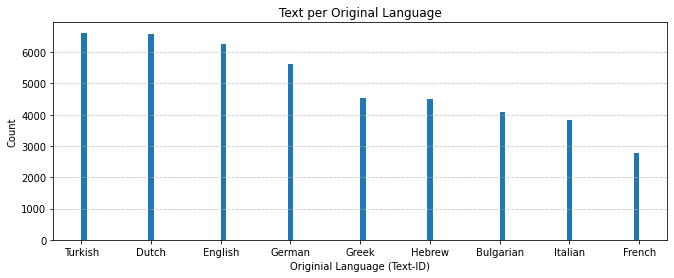

In [72]:
plt.figure(figsize=(11, 4))
plt.hist(inds, bins=100, weights=vals)
plt.xlabel("Originial Language (Text-ID)")
plt.ylabel("Count")
plt.title("Text per Original Language")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show();

### 1.2. Paragraph quantity distribution (Sentence-ID)

In [73]:
inds, vals = (sentences_train['Sentence-ID'].value_counts().index,
              sentences_train['Sentence-ID'].value_counts().values) 

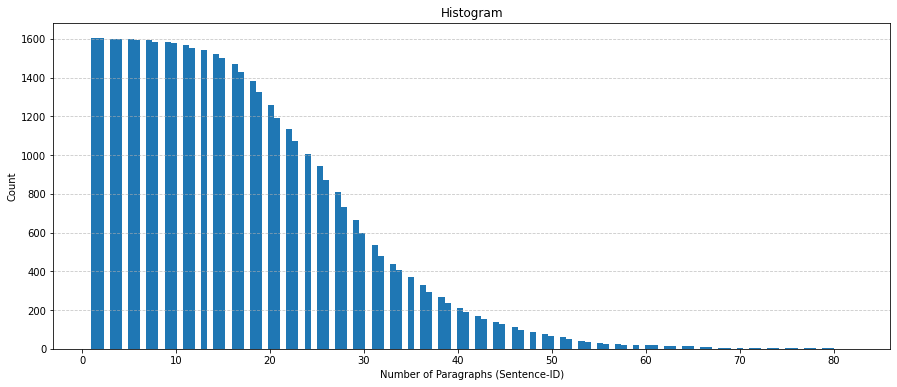

In [74]:
plt.figure(figsize=(15, 6))
plt.hist(inds, bins=125, weights=vals)
plt.xlabel("Number of Paragraphs (Sentence-ID)")
plt.ylabel("Count")
plt.title("Histogram")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show();

### 1.3. Text Analysis

#### 1.3.1 Preprocess text

In [75]:
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'\W+', ' ', text)  # Remove special characters
    tokens = word_tokenize(text)  # Tokenization
    # Remove stopwords
    tokens = [word for word in tokens if word not in stopwords.words('english')] 
    return " ".join(tokens)

In [76]:
train_df = sentences_train['Text']
test_df  = sentences_test['Text']
val_df   = sentences_val['Text']

In [77]:
train_df_inds = [str(ind)+'_tr' for ind in train_df.index]
test_df_inds  = [str(ind)+'_te' for ind in test_df.index]
val_df_inds  = [str(ind)+'_va' for ind in val_df.index]

In [78]:
train_df_inds[:3], test_df_inds[:3], val_df_inds[:3]

(['0_tr', '1_tr', '2_tr'], ['0_te', '1_te', '2_te'], ['0_va', '1_va', '2_va'])

In [79]:
train_df_text = pd.DataFrame(sentences_train['Text'].values, columns=['Text'])
test_df_text  = pd.DataFrame(sentences_test['Text'].values, columns=['Text'])
val_df_text   = pd.DataFrame(sentences_val['Text'].values, columns=['Text'])

In [80]:
all_sentences = pd.DataFrame(pd.concat([train_df_text, test_df_text, val_df_text]))

In [81]:
# Basic Preprocess
all_sentences["clean_Text"] = all_sentences["Text"].apply(preprocess_text)

In [82]:
all_sentences.head()

,Text,clean_Text
0,Hispanic Voters Are Losing Faith In The Democratic Party: Poll,hispanic voters losing faith democratic party poll
1,"The support of Hispanic voters at the midterms later this year could prove to be “extremely instrumental” in turning the tide of liberal policies of the current administration, a conservative Hispanic group says.",support hispanic voters midterms later year could prove extremely instrumental turning tide liberal policies current administration conservative hispanic group says
2,"U.S. President Joe Biden speaks to employees at Lockheed Martin, a facility that manufactures weapon systems such as Javelin anti-tank missiles, in Troy, Alabama, on May 3, 2022.",u president joe biden speaks employees lockheed martin facility manufactures weapon systems javelin anti tank missiles troy alabama may
3,"(Julie Bennett/Getty Images) According to a Quinnipiac University poll published in April, only 26 percent of Hispanic survey participants approved of President Joe Biden’s job performance.",julie bennett getty images according quinnipiac university poll published april percent hispanic survey participants approved president joe biden job performance
4,This marks the lowest approval rating of any demographic group.,marks lowest approval rating demographic group


#### 1.3.2 Seentences length Distribution

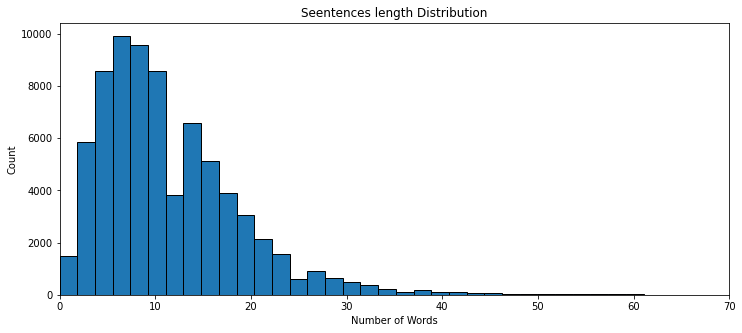

In [83]:
all_sentences["num_words"] = all_sentences["clean_Text"]\
                                .apply(lambda x: len(x.split()))

plt.figure(figsize=(12,5))
plt.hist(all_sentences["num_words"], bins=100, edgecolor="black")
plt.xlabel("Number of Words")
plt.ylabel("Count")
plt.xlim(0,70)
plt.title("Seentences length Distribution")
plt.show();

In [84]:
print(f'Total sentences in the Dataset: {len(all_sentences)}')

Total sentences in the Dataset: 74231


In [85]:
print(f'Average of words per text: {all_sentences["num_words"].mean():.0f} words.')
print(f'Median of words per text:  {all_sentences["num_words"].median():.0f} words.')
print(f'Std of words per text:     {all_sentences["num_words"].std():.0f} words.')
print(f'Max of words in text:      {all_sentences["num_words"].max():.0f} words.')
print(f'Min of words in text:      {all_sentences["num_words"].min():.0f} words.')

Average of words per text: 11 words.
Median of words per text:  10 words.
Std of words per text:     8 words.
Max of words in text:      185 words.
Min of words in text:      0 words.


In [86]:
words     = all_sentences["num_words"].value_counts().index
num_texts = all_sentences["num_words"].value_counts().values

for x,y in zip(words, num_texts):
    if y <= 1:
        print(f'{y} text has {x} words.')
    else:
        print(f'{y} texts have {x} words.')

4960 texts have 7 words.
4960 texts have 6 words.
4891 texts have 8 words.
4670 texts have 9 words.
4546 texts have 5 words.
4525 texts have 10 words.
4043 texts have 11 words.
4042 texts have 4 words.
3820 texts have 12 words.
3453 texts have 13 words.
3367 texts have 3 words.
3148 texts have 14 words.
2711 texts have 15 words.
2475 texts have 2 words.
2398 texts have 16 words.
2087 texts have 17 words.
1815 texts have 18 words.
1688 texts have 19 words.
1355 texts have 20 words.
1269 texts have 1 words.
1204 texts have 21 words.
920 texts have 22 words.
840 texts have 23 words.
721 texts have 24 words.
605 texts have 25 words.
505 texts have 26 words.
424 texts have 27 words.
341 texts have 28 words.
318 texts have 29 words.
257 texts have 30 words.
215 texts have 31 words.
214 texts have 0 words.
189 texts have 32 words.
180 texts have 33 words.
118 texts have 34 words.
115 texts have 35 words.
102 texts have 36 words.
88 texts have 37 words.
84 texts have 38 words.
61 texts have 39

#### 1.3.3. Most used words frequency 

In [87]:
def top_list(word_freq, top=25):
    for i,x in enumerate(word_freq.most_common(top)):
        print(f'{i+1}º: {x[0]} {x[1]}')

def top_to_dict(word_freq, top=25):
    return dict(word_freq.most_common(top))

def plot_top(freq_data, top=25):
    plt.figure(figsize=(12,6))
    plt.bar(top_to_dict(freq_data, top).keys(), 
            top_to_dict(freq_data, top).values())
    plt.xlabel('Word')
    plt.ylabel('Count')
    plt.title(f'Top {top} - Most Frequent Words')
    plt.xticks(rotation=45)
    plt.show();

In [88]:
# Join sentences and Tokenize 
all_words = " ".join(all_sentences["clean_Text"]).split()
word_freq = Counter(all_words)

In [89]:
top_list(word_freq, 25)

1º: also 4817
2º: said 4669
3º: people 3612
4º: quot 3071
5º: one 2780
6º: new 2762
7º: year 2586
8º: time 2359
9º: government 2282
10º: according 2178
11º: would 2166
12º: country 2126
13º: minister 2034
14º: years 2000
15º: us 1971
16º: state 1908
17º: first 1893
18º: european 1849
19º: two 1720
20º: work 1659
21º: percent 1621
22º: president 1608
23º: last 1559
24º: world 1516
25º: public 1506


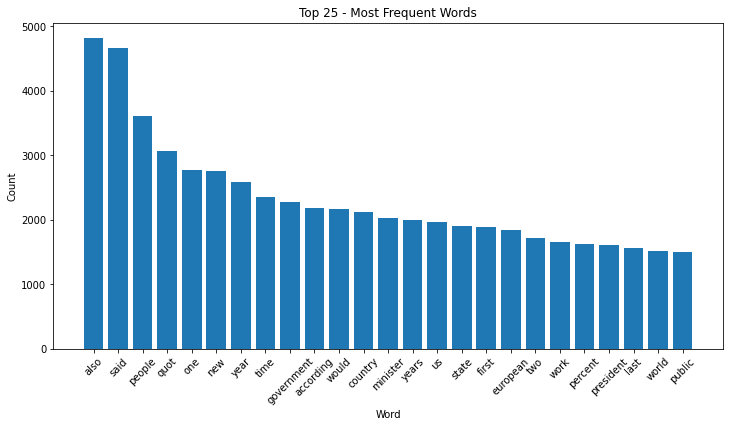

In [90]:
plot_top(word_freq, 25)

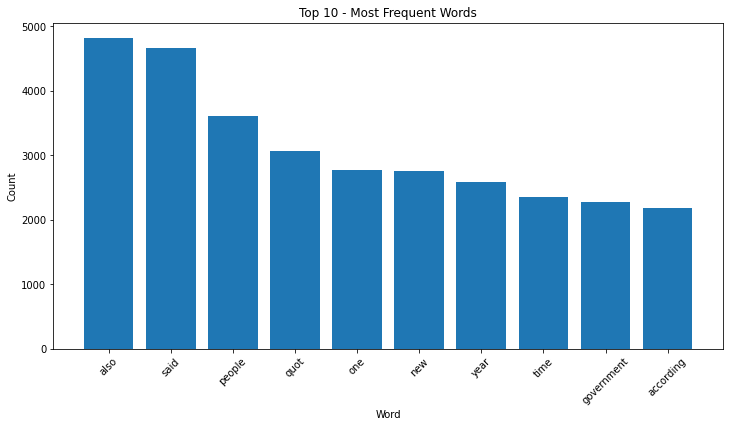

In [91]:
plot_top(word_freq, 10)

#### 1.3.4 N-Gramas

In [92]:
def get_ngrams(text, n=2):
    tokens = word_tokenize(text)
    n_grams = list(ngrams(tokens, n))
    return [" ".join(gram) for gram in n_grams]

def extract_ngrams(df, ng=2):
    return df["clean_Text"].apply(lambda x: get_ngrams(x, ng))

In [93]:
all_sentences['bigrams'] = extract_ngrams(all_sentences, 2)
all_sentences['trigrams'] = extract_ngrams(all_sentences, 3)

In [94]:
all_sentences.head(1)

,Text,clean_Text,num_words,bigrams,trigrams
0,Hispanic Voters Are Losing Faith In The Democratic Party: Poll,hispanic voters losing faith democratic party poll,7,"[hispanic voters, voters losing, losing faith, faith democratic, democratic party, party poll]","[hispanic voters losing, voters losing faith, losing faith democratic, faith democratic party, democratic party poll]"


In [95]:
# Most common bigrams
bigram_freq = Counter([bigram for sublist in all_sentences["bigrams"].tolist() 
                                   for bigram in sublist])

In [96]:
# Top Bigrams
top_list(bigram_freq, 20)

1º: prime minister 664
2º: last year 408
3º: united states 329
4º: year old 324
5º: european union 267
6º: young people 243
7º: member states 236
8º: first time 218
9º: long term 215
10º: human rights 209
11º: minimum wage 201
12º: years ago 195
13º: climate change 187
14º: last week 182
15º: billion euros 176
16º: european commission 167
17º: donald trump 160
18º: social media 159
19º: natural gas 156
20º: recent years 153


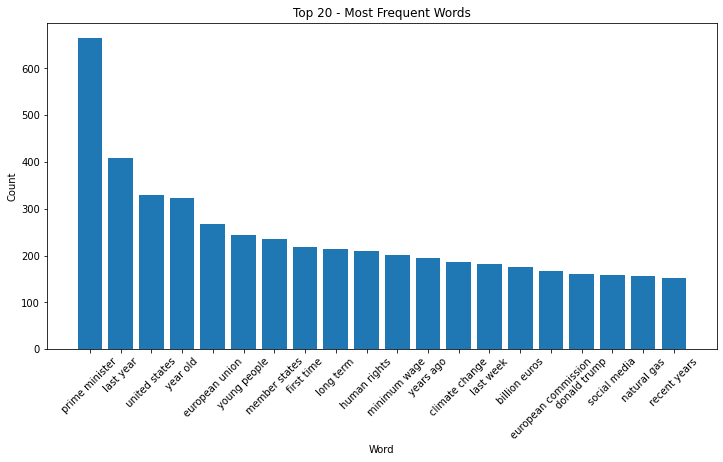

In [97]:
plot_top(bigram_freq, 20)

In [98]:
# Most common trigrams
trigram_freq = Counter([trigram for sublist in all_sentences["trigrams"].tolist() 
                                   for trigram in sublist])

In [99]:
# Top Bigrams
top_list(trigram_freq, 20)

1º: president donald trump 89
2º: von der leyen 74
3º: president recep tayyip 69
4º: recep tayyip erdoğan 65
5º: president joe biden 61
6º: eu member states 58
7º: united arab emirates 53
8º: ursula von der 43
9º: public prosecutor office 42
10º: deputy prime minister 41
11º: world health organization 40
12º: small medium sized 36
13º: president vladimir putin 35
14º: c c partly 35
15º: us president donald 32
16º: children young people 30
17º: british prime minister 30
18º: greenhouse gas emissions 30
19º: russian president vladimir 29
20º: renewable energy sources 29


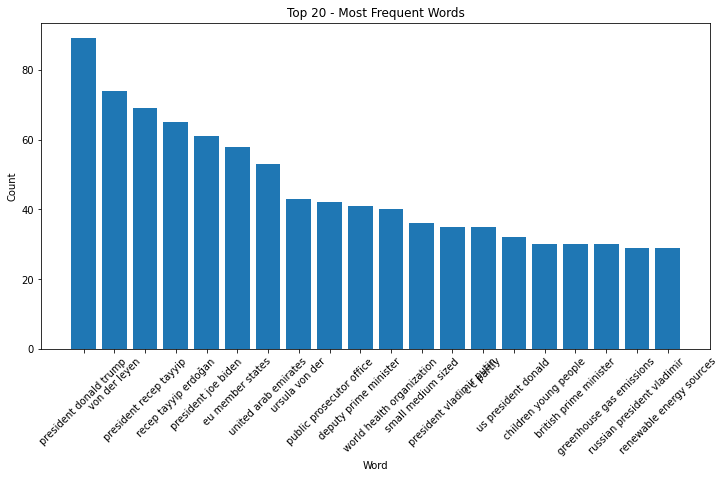

In [100]:
plot_top(trigram_freq, 20)

#### 1.3.5 TF-IDF Analysis

In [101]:
 # Most relevant terms (Top 50)
vectorizer = TfidfVectorizer(max_features=50)
tfidf_matrix = vectorizer.fit_transform(all_sentences["clean_Text"])
feature_names = vectorizer.get_feature_names_out()

In [102]:
# Convertir a dataframe
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

In [103]:
# Mostrar las 10 palabras más significativas según TF-IDF
print(tfidf_df.mean().sort_values(ascending=False).head(10))

also          0.044687
said          0.039767
people        0.031608
one           0.024751
new           0.024478
quot          0.021521
year          0.021163
time          0.021095
government    0.020162
according     0.020060
dtype: float64


#### 1.3.6 Sentiment Analysis

In [104]:
sia = SentimentIntensityAnalyzer()

In [105]:
## Calculate sentiment for each sentence
all_sentences["sentiment"] = all_sentences["Text"]\
                        .apply(lambda x: sia.polarity_scores(x)["compound"])

# Clasificate sentences: positive, negative or neutral
all_sentences["sentiment_label"] = all_sentences["sentiment"]\
                            .apply(lambda x: "positive" if x > 0.05 
                                   else ("negative" if x < -0.05 else "neutral"))

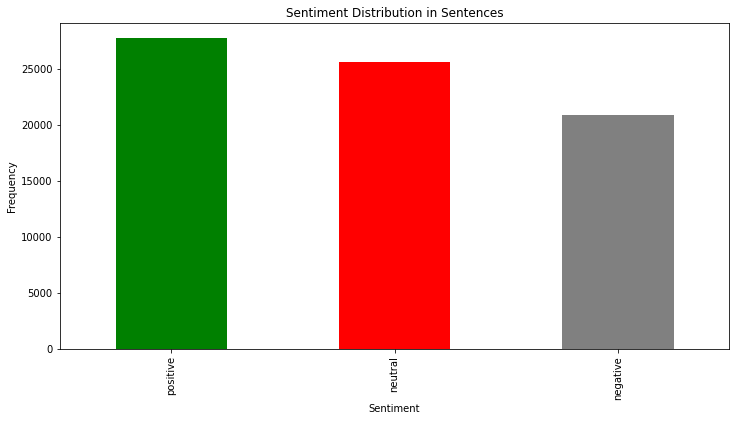

In [106]:
all_sentences["sentiment_label"].value_counts()\
                .plot(kind="bar", color=["green", "red", "gray"],
                     figsize=(12,6))
plt.title("Sentiment Distribution in Sentences")
plt.xlabel("Sentiment")
plt.ylabel("Frequency")
plt.show();

#### 1.3.7 Grammar Categorization

In [107]:
codes = """\
CC-Coordinating conjunction
CD-Cardinal number
DT-Determiner 
EX-Existential
FW-Foreign word 
IN-Subordinating preposition or conjunction 
JJ-Adjective Adjective
JJR-Comparative adjective 
JJS-Superlative adjective
LS-List marker
MD-Modal verb
NN-Singular noun
NNS-Plural noun
NNP-Proper noun singular
NNPS-Plural proper noun 
PDT-Predeterminer 
POS-Possession mark
PRP-Personal pronoun 
PRP$-Possessive pronoun 
RB-Adverb 
RBR-Comparative adverb 
RBS-Superlative adverb 
RP-Particle
SYM-Symbol 
TO-“to” as preposition
UH-Interjection
VB-Base verb
VBD-Verb in past tense
VBG-Verb in gerund
VBN-Verb in past participle
VBP-Present tense verb (except “is”)
VBZ-Verb in 3rd person present tense 
WDT-Relative pronoun or determiner
WP-Relative pronoun"""

dic_grammar_types = {}
with open('grammar_dict.txt', 'w') as f:
    text = f.write(codes)
with open('grammar_dict.txt') as f:
    for l in f.readlines():
        t = l.rstrip('\n ').split('-')
        dic_grammar_types[t[0]] = t[1]

In [108]:
grammar_dict = {}
for s in all_sentences['clean_Text']:
    tokens = word_tokenize(s)
    pos_tags = pos_tag(tokens)
    for word, tag in pos_tags:
        try:
            grammar_dict[tag].append(word)
        except KeyError:
            grammar_dict[tag] = [word]

In [109]:
gram_categ_distrib = pd.DataFrame(
    data    = [(k, len(v)) for k,v in grammar_dict.items()],
    columns = ['tag', 'sum']
).sort_values('sum', ascending=False)

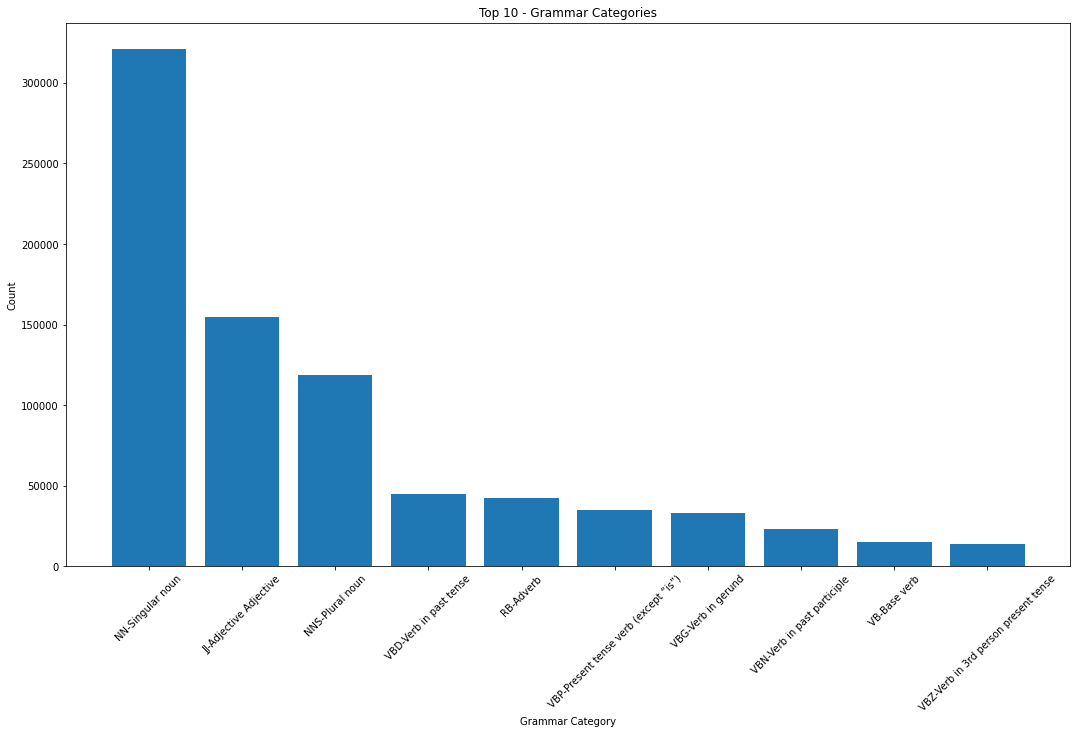

In [110]:
descript_tags = [ g+'-'+dic_grammar_types[g] 
                 for g in gram_categ_distrib['tag'].values[:10]]
plt.figure(figsize=(18,10))
plt.bar(descript_tags, 
        gram_categ_distrib['sum'].values[:10])
plt.title('Top 10 - Grammar Categories')
plt.xlabel('Grammar Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show();

In [111]:
## Tokenize and POS for each sentence
pos_tags_list = []
words_by_pos = []

for sentence in all_sentences['clean_Text']:
    tokens = word_tokenize(sentence)
    pos_tags = pos_tag(tokens)
    pos_tags_list.extend(pos_tags)
    words_by_pos.extend([tag for word, tag in pos_tags])

df_pos = pd.DataFrame(pos_tags_list, columns=["Word", "POS"])

In [112]:
top_n = 10
print("\n### Most Frequent Words for each category ###")
for pos in grammar_dict.keys():
    top_words = df_pos[df_pos["POS"] == pos]["Word"].value_counts().head(top_n)
    if not top_words.empty:
        print(f"\nTOP {top_n} palabras de {pos}:")
        print(top_words)


### Most Frequent Words for each category ###

TOP 10 palabras de JJ:
Word
new         2762
european    1820
last        1559
many        1479
public      1416
national    1262
social      1234
economic    1053
high        1022
first        973
Name: count, dtype: int64

TOP 10 palabras de NNS:
Word
people       3612
years        2000
countries    1381
children     1075
companies     973
days          834
states        826
measures      773
months        756
citizens      658
Name: count, dtype: int64

TOP 10 palabras de VBG:
Word
according    2178
including     853
working       717
going         547
following     544
taking        368
making        355
coming        343
regarding     320
beginning     290
Name: count, dtype: int64

TOP 10 palabras de NN:
Word
year          2586
time          2359
government    2282
country       2126
minister      2034
state         1908
quot          1708
president     1608
world         1516
energy        1501
Name: count, dtype: int64

TOP 10 pal

In [113]:
# Most Common Grammar Patterns
import seaborn as sns

bigrams = list(ngrams(words_by_pos, 2))
trigrams = list(ngrams(words_by_pos, 3))

bigram_counts = Counter(bigrams).most_common(10)
trigram_counts = Counter(trigrams).most_common(10)

print("\n### Most Common Grammar Bigrams ###")
for bigram, count in bigram_counts:
    print(f"{bigram} - {count} veces")

print("\n### Most Common Grammar Trigrams ###")
for trigram, count in trigram_counts:
    print(f"{trigram} - {count} veces")


### Most Common Grammar Bigrams ###
('NN', 'NN') - 138649 veces
('JJ', 'NN') - 86151 veces
('NN', 'JJ') - 41870 veces
('NN', 'NNS') - 41640 veces
('JJ', 'NNS') - 32766 veces
('NN', 'VBD') - 25617 veces
('NNS', 'VBP') - 23855 veces
('JJ', 'JJ') - 23497 veces
('NNS', 'NN') - 21009 veces
('NNS', 'JJ') - 18528 veces

### Most Common Grammar Trigrams ###
('NN', 'NN', 'NN') - 59522 veces
('JJ', 'NN', 'NN') - 38585 veces
('NN', 'JJ', 'NN') - 24850 veces
('NN', 'NN', 'JJ') - 17906 veces
('NN', 'NN', 'NNS') - 15419 veces
('JJ', 'JJ', 'NN') - 14360 veces
('NN', 'NN', 'VBD') - 13180 veces
('JJ', 'NN', 'NNS') - 12120 veces
('JJ', 'NN', 'JJ') - 11177 veces
('NN', 'NNS', 'VBP') - 9897 veces


## 2. Labels Analysis

In [114]:
print(f'################\n#### LABELS ####\n################\n')
print(f'TRAIN\n   Filas: {labels_train.shape[0]}\n   Columnas: {labels_train.shape[1]}')
print(f'TEST\n   Filas: {labels_test.shape[0]}\n   Columnas: {labels_test.shape[1]}')
print(f'VAL\n   Filas: {labels_val.shape[0]}\n   Columnas: {labels_val.shape[1]}')

################
#### LABELS ####
################

TRAIN
   Filas: 44758
   Columnas: 48
TEST
   Filas: 14569
   Columnas: 48
VAL
   Filas: 14904
   Columnas: 48


In [115]:
labels_train['Text-ID'].value_counts().values

array([82, 80, 76, ...,  3,  2,  2])

In [120]:
### ARE THERE THE SAME TEXT-ID VALUES IN LABELS AND SENTENCES? 
list(labels_train['Text-ID'].value_counts().values) == list(sentences_train['Text-ID'].value_counts().values)

True

### 2.1 Categories and Subcategories Analysis

In [121]:
### Exclude two first columns (IDs) and the last 8 (Value Categories)
subcateg_train = labels_train.iloc[:, 2:-8].sum()*100/len(labels_train)
subcateg_test  = labels_test.iloc[:, 2:-8].sum()*100/len(labels_val)
subcateg_val   = labels_val.iloc[:, 2:-8].sum()*100/len(labels_test)

### Frequency count dataset
df_counts = pd.DataFrame({
    'Train': subcateg_train,
    'Validation': subcateg_val,
    'Test': subcateg_test
}).T  # Transpose so that the labels are the columns 

<Figure size 1008x720 with 0 Axes>

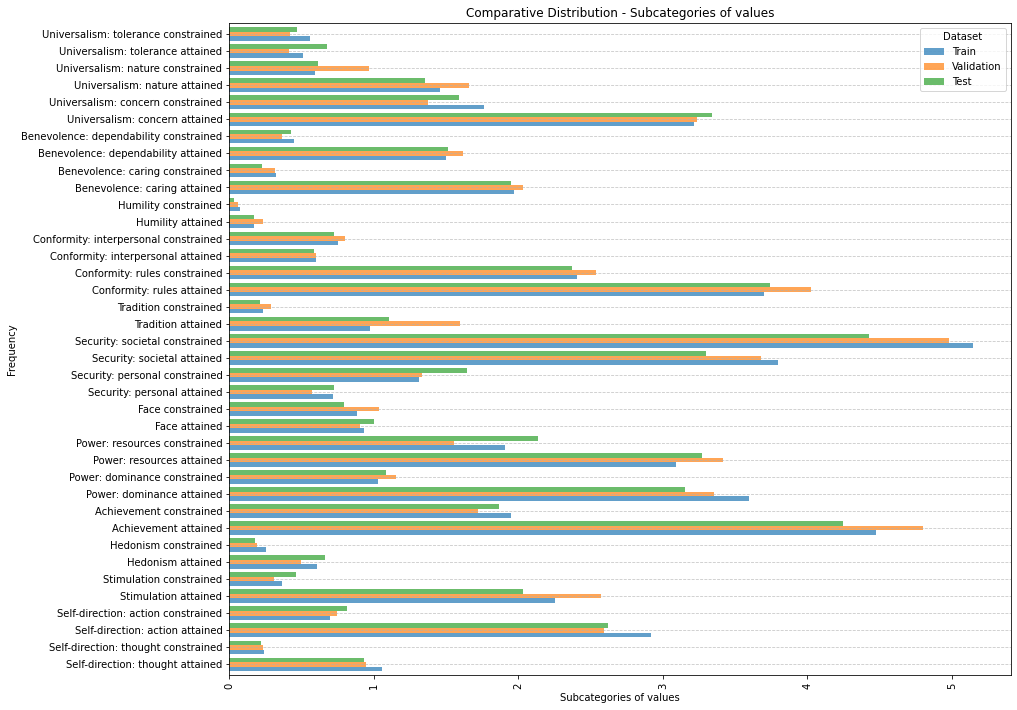

In [122]:
plt.figure(figsize=(14, 10))
df_counts.T.plot(kind="barh", figsize=(14,12), alpha=0.7, width=0.8)
plt.xlabel("Subcategories of values")
plt.ylabel("Frequency")
plt.title("Comparative Distribution - Subcategories of values")
plt.xticks(rotation=90)
plt.legend(title="Dataset")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show();

In [123]:
# Label freq count
def count_labels(df, category_columns, subcategory_columns):
    category_counts = df[category_columns].sum()
    subcategory_counts = df[subcategory_columns].sum()
    return category_counts, subcategory_counts

# Visualize Distribution
def plot_label_distribution(df, title, xlabel, ylabel):
    df_melted = df.melt(id_vars=[df.columns[0]], var_name="Dataset", value_name="Count")
    plt.figure(figsize=(12, 6))
    sns.barplot(x=df_melted.columns[0], y="Count", hue="Dataset", data=df_melted)
    plt.xticks(rotation=90)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(title="Dataset")
    plt.show()

In [124]:
# Column names
column_names  = labels_train.columns
id_columns    = column_names[:2] # IDs
categ_cols    = column_names[-8:] # Categories
subcateg_cols = column_names[2:-8] # Subcategories

# Split Attained and Constrained Category columns
attain_categ_cols   = categ_cols[::2]  # Odd Columns
constr_categ_cols   = categ_cols[1::2]  # Even Columns

# Split Attained and Constrained Subcategory columns
attain_subcateg_cols   = subcateg_cols[::2]  # Odd Columns
constr_subcateg_cols   = subcateg_cols[1::2]  # Even Columns

In [125]:
# Labels for each Dataset - ATTAINED
train_categ_att_count, train_subcateg_att_count = count_labels(labels_train, attain_categ_cols, 
                                                               attain_subcateg_cols)
val_categ_att_count,   val_subcateg_att_count   = count_labels(labels_val, attain_categ_cols, 
                                                               attain_subcateg_cols)
test_categ_att_count,  test_subcateg_att_count  = count_labels(labels_test, attain_categ_cols, 
                                                               attain_subcateg_cols)

# Labels for each Dataset - CONSTRAINED
train_categ_cons_count, train_subcateg_cons_count = count_labels(labels_train, constr_categ_cols, 
                                                               constr_subcateg_cols)
val_categ_cons_count,   val_subcateg_cons_count   = count_labels(labels_val, constr_categ_cols, 
                                                               constr_subcateg_cols)
test_categ_cons_count,  test_subcateg_cons_count  = count_labels(labels_test, constr_categ_cols, 
                                                               constr_subcateg_cols)

In [126]:
### DATASET - CATEGORY ATTAINED
category_counts_att_df = pd.DataFrame({
    'Train': train_categ_att_count,
    'Validation': val_categ_att_count,
    'Test': test_categ_att_count
}).reset_index().rename(columns={'index': 'Category_Attained'})

### DATASET - CATEGORY CONSTRAINED
category_counts_cons_df = pd.DataFrame({
    'Train': train_categ_cons_count,
    'Validation': val_categ_cons_count,
    'Test': test_categ_cons_count
}).reset_index().rename(columns={'index': 'Category_Constrained'})

### DATASET - SUBCATEGORY ATTAINED
subcategory_counts_att_df = pd.DataFrame({
    'Train': train_subcateg_att_count,
    'Validation': val_subcateg_att_count,
    'Test': test_subcateg_att_count
}).reset_index().rename(columns={'index': 'Subcategory_Attained'})

### DATASET - SUBCATEGORY CONSTRAINED
subcategory_counts_cons_df = pd.DataFrame({
    'Train': train_subcateg_cons_count,
    'Validation': val_subcateg_cons_count,
    'Test': test_subcateg_cons_count
}).reset_index().rename(columns={'index': 'Subcategory_Constrained'})

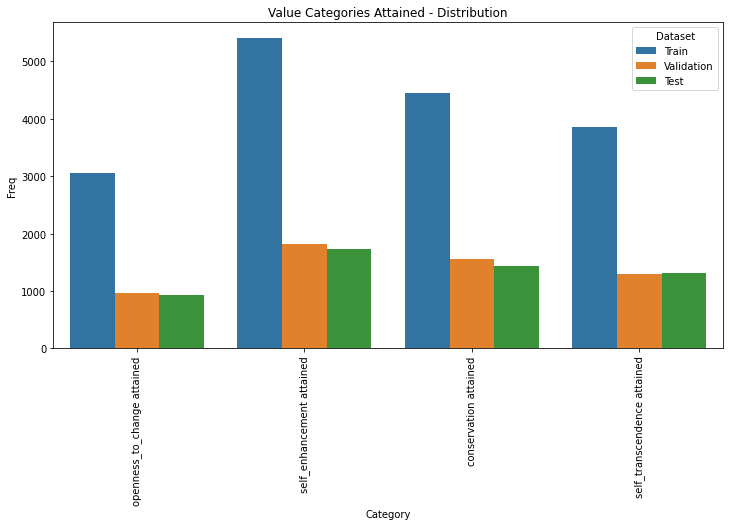

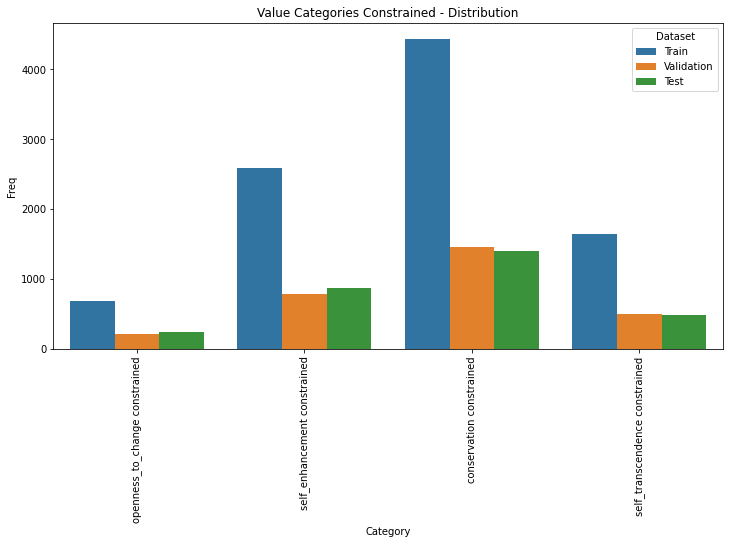

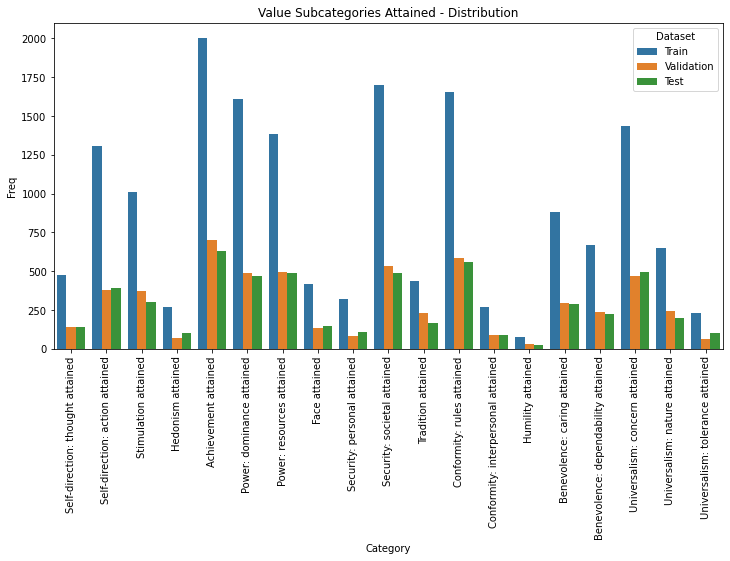

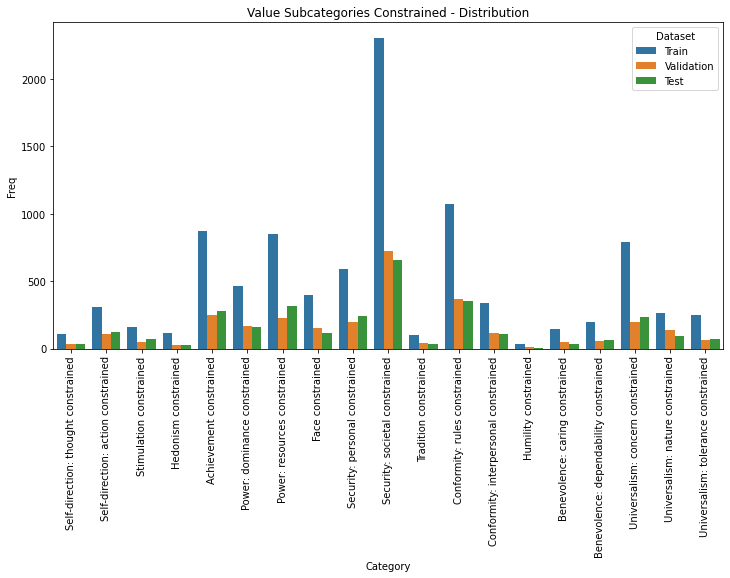

In [127]:
### PLOT DISTRIBUTION - CATEGORIES ATTAINED 
plot_label_distribution(category_counts_att_df, 
                        "Value Categories Attained - Distribution", 
                        "Category", "Freq")
### PLOT DISTRIBUTION - CATEGORIES ATTAINED 
plot_label_distribution(category_counts_cons_df, 
                        "Value Categories Constrained - Distribution", 
                        "Category", "Freq")

### PLOT DISTRIBUTION - SUBCATEGORIES ATTAINED 
plot_label_distribution(subcategory_counts_att_df, 
                        "Value Subcategories Attained - Distribution", 
                        "Category", "Freq")

### PLOT DISTRIBUTION - SUBCATEGORIES CONSTRAINED 
plot_label_distribution(subcategory_counts_cons_df, 
                        "Value Subcategories Constrained - Distribution", 
                        "Category", "Freq")

### 2.2 Separabilidad de Clases

In [128]:
# Jaccard and Cosine
def compute_similarity_matrix(data, metric='jaccard'):
    return 1 - squareform(pdist(data.T, metric=metric))

In [129]:
# Only Extract label columns
subcategory_columns = labels_train.columns[2:-8]
train_labels_matrix = labels_train[subcategory_columns].to_numpy()

In [130]:
jaccard_sim_matrix = compute_similarity_matrix(train_labels_matrix, metric='jaccard')
cosine_sim_matrix  = compute_similarity_matrix(train_labels_matrix, metric='cosine')

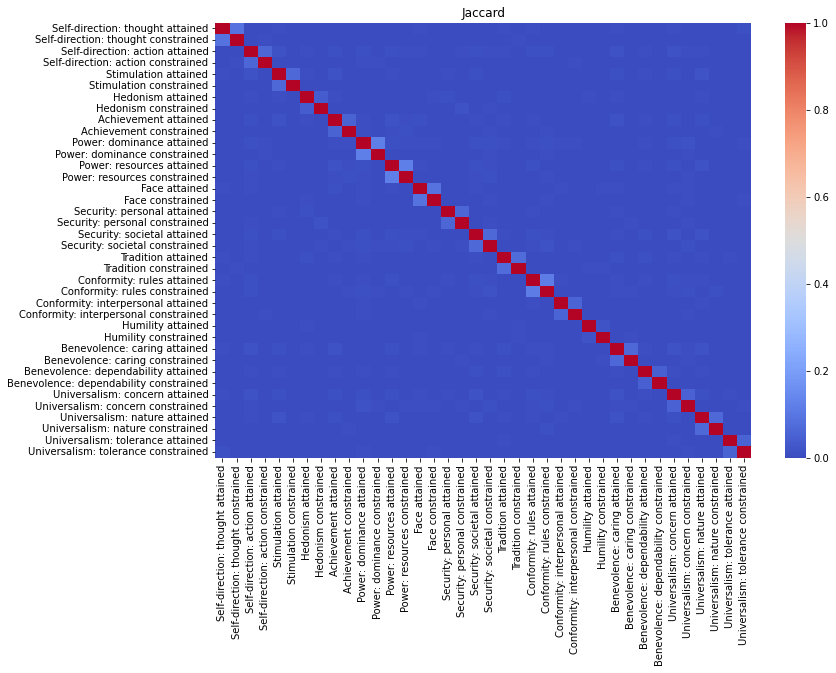

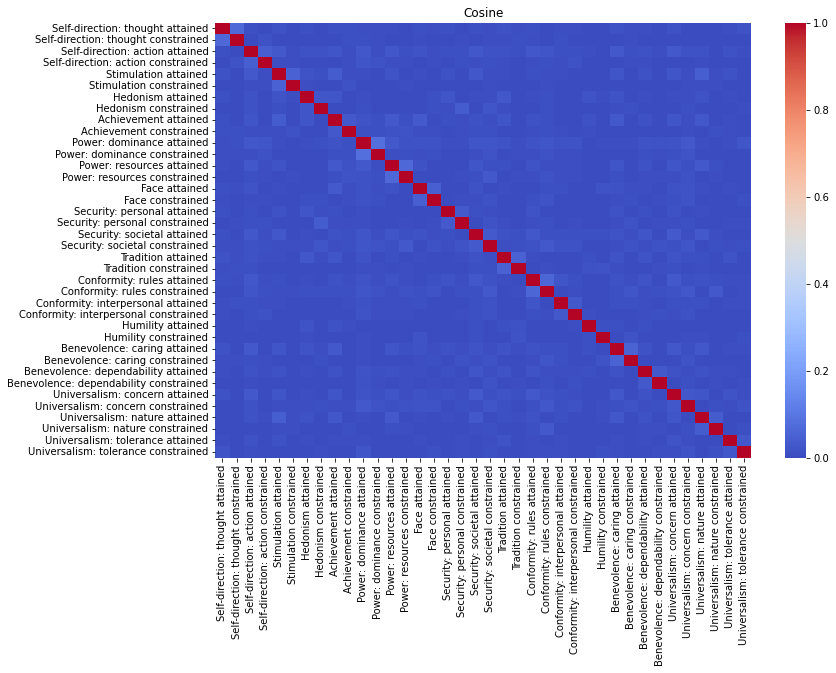

In [131]:
# Visualize Similarity Matrix
plt.figure(figsize=(12, 8))
sns.heatmap(jaccard_sim_matrix, xticklabels=subcategory_columns, 
            yticklabels=subcategory_columns, cmap="coolwarm")
plt.title("Jaccard")
plt.show()

plt.figure(figsize=(12, 8))
sns.heatmap(cosine_sim_matrix, xticklabels=subcategory_columns, 
            yticklabels=subcategory_columns, cmap="coolwarm")
plt.title("Cosine")
plt.show()

### 2.3 Evaluación del Sesgo de Anotación

In [132]:
# Compare Distributions: train, val and test
def compare_distributions(train, val, test):
    train_dist = train.sum(axis=0) / train.shape[0]
    val_dist = val.sum(axis=0) / val.shape[0]
    test_dist = test.sum(axis=0) / test.shape[0]
    return pd.DataFrame({'Train': train_dist, 
                         'Validation': val_dist, 
                         'Test': test_dist}, index=subcategory_columns)

# Bias Identification
def detect_annotation_bias(train, val, test):
    combined_data = np.vstack([train.sum(axis=0), val.sum(axis=0), test.sum(axis=0)])
    chi2_results = [chi2_contingency(np.array([combined_data[:, i]] * 3))[1] 
                    for i in range(combined_data.shape[1])]
    return pd.DataFrame({'Subcategory': subcategory_columns,
                         'p-value': chi2_results}).sort_values('p-value')

# Balanced Evaluation Labels 
def evaluate_balance(data):
    label_proportions = data.sum(axis=0) / data.shape[0]
    return pd.DataFrame({'Subcategory': subcategory_columns, 
                         'Proportion': label_proportions}).sort_values('Proportion')

In [133]:
# Convett to binary matrix
val_labels_matrix = labels_val[subcategory_columns].to_numpy()
test_labels_matrix = labels_test[subcategory_columns].to_numpy()

In [134]:
distribution_comparison = compare_distributions(train_labels_matrix, 
                                                val_labels_matrix, 
                                                test_labels_matrix)
annotation_bias = detect_annotation_bias(train_labels_matrix, 
                                         val_labels_matrix, 
                                         test_labels_matrix)
balance_analysis = evaluate_balance(train_labels_matrix)

print(distribution_comparison)
print(annotation_bias)
print(balance_analysis)

                                           Train  Validation      Test
Self-direction: thought attained        0.010568    0.009226  0.009506
Self-direction: thought constrained     0.002368    0.002248  0.002231
Self-direction: action attained         0.029179    0.025362  0.026803
Self-direction: action constrained      0.006948    0.007246  0.008340
Stimulation attained                    0.022532    0.025161  0.020763
Stimulation constrained                 0.003653    0.003019  0.004702
Hedonism attained                       0.006066    0.004864  0.006795
Hedonism constrained                    0.002558    0.001845  0.001785
Achievement attained                    0.044718    0.046934  0.043448
Achievement constrained                 0.019516    0.016808  0.019082
Power: dominance attained               0.035982    0.032776  0.032226
Power: dominance constrained            0.010311    0.011239  0.011085
Power: resources attained               0.030933    0.033414  0.033427
Power:

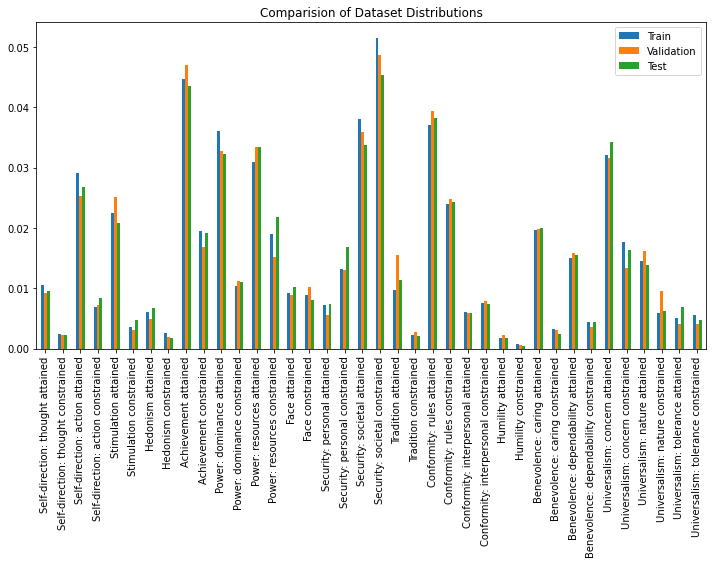

In [135]:
# Visualize Distribution
distribution_comparison.plot(kind='bar', figsize=(12,6), 
                        title="Comparision of Dataset Distributions")
plt.xticks(rotation=90)
plt.show();

## 3. Labels and Sentences

In [139]:
pd.options.mode.use_inf_as_na = True

/var/folders/53/dw47g4ws1tjgp55kjvh6r1r80000gn/T/ipykernel_7511/1760459698.py:1: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.options.mode.use_inf_as_na = True


In [136]:
id_columns = ['Text-ID', 'Sentence-ID']

train_merged = pd.merge(sentences_train, labels_train, on=id_columns, how='inner')
val_merged   = pd.merge(sentences_val, labels_val, on=id_columns, how='inner')
test_merged  = pd.merge(sentences_test, labels_test, on=id_columns, how='inner')

print("Train Merged Shape:", train_merged.shape)
print("Validation Merged Shape:", val_merged.shape)
print("Test Merged Shape:", test_merged.shape)

Train Merged Shape: (44758, 50)
Validation Merged Shape: (14904, 50)
Test Merged Shape: (14569, 50)


In [ ]:
#train_merged.to_csv('../DATA/data_human_value/train_merged.tsv', sep='\t', index=False)
#test_merged.to_csv('../DATA/data_human_value/test_merged.tsv', sep='\t', index=False)
#val_merged.to_csv('../DATA/data_human_value/val_merged.tsv', sep='\t', index=False)

### 3.1 Number of Labels per Phrase

In [137]:
train_merged['num_labels'] = train_merged[subcategory_columns].sum(axis=1)
val_merged['num_labels']   = val_merged[subcategory_columns].sum(axis=1)
test_merged['num_labels']  = test_merged[subcategory_columns].sum(axis=1)

In [146]:
print(train_merged['num_labels'].value_counts())
print(val_merged['num_labels'].value_counts())
print(test_merged['num_labels'].value_counts())

num_labels
0.0    21696
1.0    20422
2.0     2268
3.0      304
4.0       53
5.0       13
6.0        2
Name: count, dtype: int64
num_labels
0.0    7304
1.0    6724
2.0     765
3.0      89
4.0      20
5.0       2
Name: count, dtype: int64
num_labels
0.0    7167
1.0    6501
2.0     786
3.0      98
4.0      15
7.0       1
5.0       1
Name: count, dtype: int64


### 3.2 Relationship between Sentences Length and Number of Labels

In [142]:
train_merged['sentence_length'] = train_merged['Text'].apply(lambda x: len(str(x).split()))
val_merged['sentence_length'] = val_merged['Text'].apply(lambda x: len(str(x).split()))
test_merged['sentence_length'] = test_merged['Text'].apply(lambda x: len(str(x).split()))

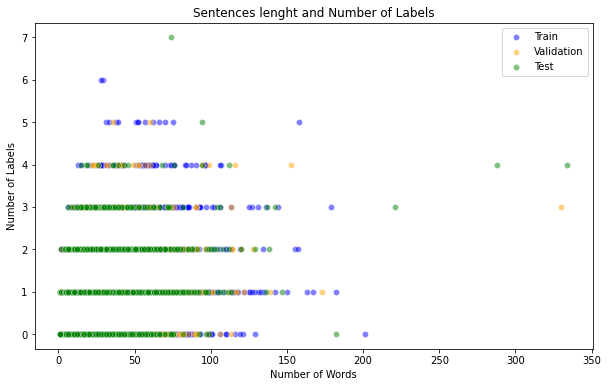

In [148]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=train_merged['sentence_length'], y=train_merged['num_labels'], 
                alpha=0.5, label="Train", color="blue")
sns.scatterplot(x=val_merged['sentence_length'], y=val_merged['num_labels'], 
                alpha=0.5, label="Validation", color="orange")
sns.scatterplot(x=test_merged['sentence_length'], y=test_merged['num_labels'], 
                alpha=0.5, label="Test", color="green")
plt.xlabel("Number of Words")
plt.ylabel("Number of Labels")
plt.title("Sentences lenght and Number of Labels")
plt.legend()
plt.show();

### 3.3 Relationship between Label Types and Phrase Lengths

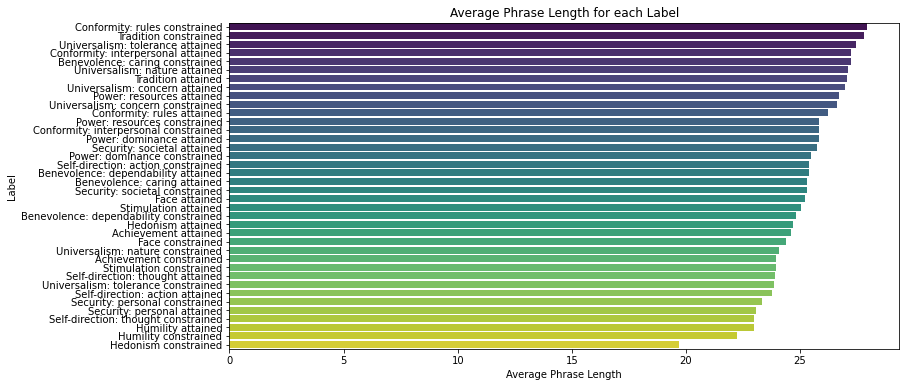

In [149]:
label_avg_length = {}
for label in subcategory_columns:
    avg_length = train_merged[train_merged[label] == 1]['sentence_length'].mean()
    label_avg_length[label] = avg_length

# Convert to Dataframe
label_avg_length_df = pd.DataFrame(label_avg_length.items(), columns=['Label', 'Avg Sentence Length'])

plt.figure(figsize=(12, 6))
sns.barplot(x='Avg Sentence Length', y='Label', 
            data=label_avg_length_df.sort_values('Avg Sentence Length', 
                ascending=False), palette="viridis")
plt.xlabel("Average Phrase Length")
plt.ylabel("Label")
plt.title("Average Phrase Length for each Label")
plt.show();

### 3.4 Phrase Label Co-occurrence Analysis

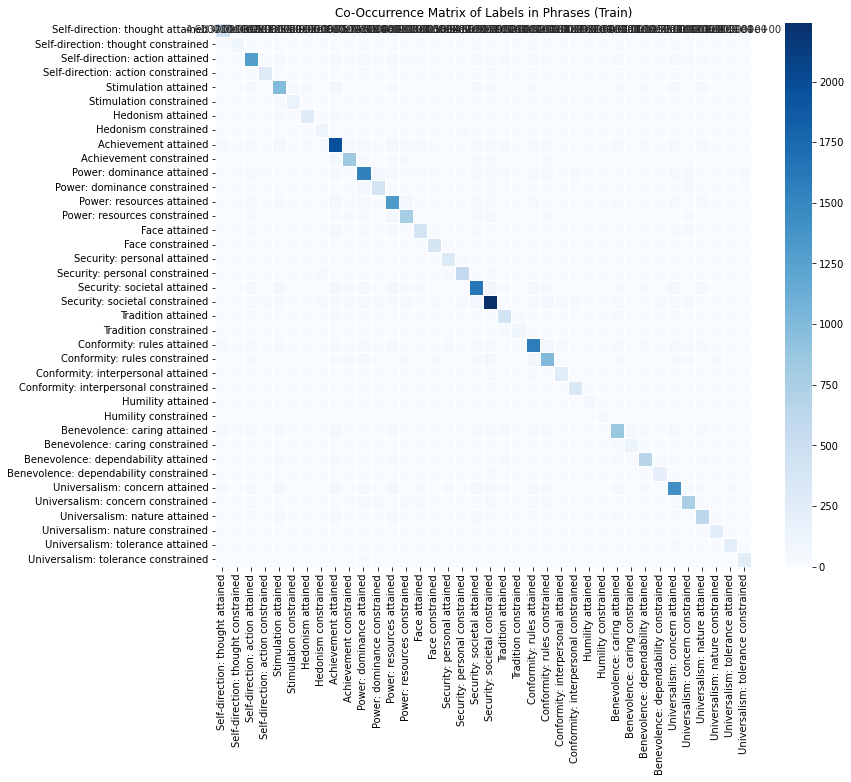

In [154]:
co_occurrence_matrix = np.dot(train_merged[subcategory_columns].T, train_merged[subcategory_columns])
co_occurrence_df = pd.DataFrame(co_occurrence_matrix, index=subcategory_columns, 
                                columns=subcategory_columns)
plt.figure(figsize=(12, 10))
sns.heatmap(co_occurrence_df, annot=True, fmt="e", cmap="Blues", linewidths=0.5)
plt.title("Co-Occurrence Matrix of Labels in Phrases (Train)")
plt.show()